# Library

In [92]:
from queries import*
from utilities import*
import os
from sklearn.linear_model import LogisticRegressionCV
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import shap
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import scipy
from scipy import stats
from scipy.spatial import distance
import sys
from io import StringIO
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import learning_curve
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_decomposition import CCA
import pathlib
from sklearn.decomposition import PCA


In [93]:
#!pip install google-cloud-bigquery
#!pip install xgboost
#!pip install shap

In [94]:
#!pip install xgboost
#!pip install shap

# Functions

In [95]:
def labeling(string, n_classes = 2, include_DR = False):
   

    
    if (n_classes == 2) and (include_DR == False):
        Patients_CR = ['1C', '1Y', '1N', '1J', '2Y', '1O', '1P','3H','1T','3M','3D','2A','2F','1R'] 
        if str(string)[0:2] in Patients_CR:
            return 1
        else:
            return 0
        
        
        
    if (n_classes == 2) and (include_DR == True):
        Patients_CR = ['1C', '1Y', '1N', '1J', '2Y', '1O', '1P','3H','1T','3M','3D','2A','2F','1R'] + ['2H', '2X','1Q','1E','2U','2R','1D','3K','1U','1G','2B','2W','1L','2M','3P']
        if str(string)[0:2] in Patients_CR:
            return 1
        else:
            return 0
        
        
        
        
    if (n_classes == 3) and(include_DR == True):
        Patients_CR = ['1C', '1Y', '1N', '1J', '2Y', '1O', '1P','3H','1T','3M','3D','2A','2F','1R'] 
        Patients_DR = ['2H', '2X','1Q','1E','2U','2R','1D','3K','1U','1G','2B','2W','1L','2M','3P']
        if str(string)[0:2] in Patients_CR:
            return 1
        if str(string)[0:2] in Patients_DR:
            return -1
        else:
            return 0    

In [96]:
def cleaning(name):
    dictio = {30:'3E1', 20:'2E1',10:'1E1'}
    if name in [30.0,20.0,10.0]:
        return dictio[int(name)]
    else :
        return name

In [97]:
def scatter_analysis(nodes_features_bool,x_name,y_name, hue = None):
    
    if nodes_features_bool:
        plt.figure(figsize=(15,7))
        plot_name = PLOT_DIRECTORY +'nodes_features_scatter_'+x_name +'_'+ y_name +'.png'
        ax =sns.scatterplot(data=nodes_features, x= x_name, y=y_name, hue=hue)
        plt.savefig(plot_name)
        
        
    else:
        
        plt.figure(figsize=(15,7))
        plot_name = PLOT_DIRECTORY +'laplace_'+x_name +'_vs_'+ y_name +'.png'
        ax = sns.scatterplot(data=laplace_quadratics_features, x=x_name,y=y_name, hue = hue)
        plt.savefig(plot_name)

In [98]:
def shuffle_and_pick(liste, number):
    
    
    random.shuffle(liste)
    train_indicies = liste[:number]
    test_indicies =liste[number:]
    
    return train_indicies, test_indicies

In [99]:
def fit_model(df, df_name,MODEL = 'forest',N_FOLDS=3, N_CLASSES = 2,MINOR_CLASS_PENALTY =10):
    
    data = df.drop(['name'],axis=1)
    data = data.reset_index()
    data = data.drop(['index'], axis = 1)
    m = len(data.columns)

    index_class_1 = list(data[data.label == 1].index)
    index_class_0 = list(data[data.label == 0].index)
    index_class_DR = list(data[data.label == -1].index)

    iterations = range(N_FOLDS)
    training_acc =[]
    testing_acc =[]
    recall_acc =[]

    for iteration in iterations:
    
        if MODEL == 'logistic':
            clf = SGDClassifier(loss = 'log', max_iter=1000, tol=1e-3, shuffle = True, learning_rate = 'adaptive',eta0=5, class_weight ='balanced',validation_fraction = 0.01)
            
        if MODEL == 'hinge':
            clf = SGDClassifier(loss = 'hinge', max_iter=1000, tol=1e-3, shuffle = True, learning_rate = 'adaptive',eta0=5, class_weight ='balanced',validation_fraction = 0.01)
            
        if MODEL == 'rbf' :  
            clf = svm.SVC(C= 1, kernel ='rbf', class_weight='balanced')
            
        if MODEL == 'poly':     
            clf = svm.SVC(C= 1, kernel ='poly', class_weight='balanced')
    
        if MODEL == 'forest'  :
            clf =  RandomForestClassifier(criterion='gini',max_depth=6, random_state=0,class_weight={0:1,1:MINOR_CLASS_PENALTY})    
        
    
        print('iteration:', iteration)
    
        if N_CLASSES == 3 :
        
            clf = OneVsRestClassifier(clf)
            train_indicies_class_1 , test_indicies_class_1 =  shuffle_and_pick(index_class_1, 10)
            train_indicies_class_0 , test_indicies_class_0 =  shuffle_and_pick(index_class_0, 20)
            train_indicies_class_DR , test_indicies_class_DR =  shuffle_and_pick(index_class_DR, 10)
            train_indicies = train_indicies_class_1 + train_indicies_class_0 + train_indicies_class_DR
            test_indicies = test_indicies_class_1 + test_indicies_class_0 + test_indicies_class_DR
        
        if (N_CLASSES == 2) and(INCLUDE_DR == False) :
        
            train_indicies_class_1 , test_indicies_class_1 =  shuffle_and_pick(index_class_1, 10)
            train_indicies_class_0 , test_indicies_class_0 =  shuffle_and_pick(index_class_0, 34)
            train_indicies = train_indicies_class_1 + train_indicies_class_0
            test_indicies = test_indicies_class_1 + test_indicies_class_0 
        
        if (N_CLASSES == 2) and(INCLUDE_DR == True) :
        
            train_indicies_class_1 , test_indicies_class_1 =  shuffle_and_pick(index_class_1, 17)
            train_indicies_class_0 , test_indicies_class_0 =  shuffle_and_pick(index_class_0, 20)
            train_indicies = train_indicies_class_1 + train_indicies_class_0
            test_indicies = test_indicies_class_1 + test_indicies_class_0         
        

        X_train =data.iloc[train_indicies,0:m-1]
        y_train = data.label.values[train_indicies]

        X_test =data.iloc[test_indicies,0:m-1]
        y_test = data.label.values[test_indicies]


        clf.fit(X_train,y_train)
        print('Training Error :')
        y_hat_train = clf.predict(X_train)
        print('True y_train :', y_train)
        print('Predicted y_train :', y_hat_train)
        training_acc.append(clf.score(X_train,y_train))
        print(confusion_matrix(y_train, y_hat_train))
    
    
        print('Testing Error :')

        y_hat = clf.predict(X_test)
        testing_acc.append(clf.score(X_test,y_test))
        recall_acc.append(recall_score(y_test, y_hat))
        print(y_hat)
        print(y_test)
        print(confusion_matrix(y_test, y_hat))
    
    
    plt.figure(figsize=(15,7))

    plt.plot(iterations,training_acc, label = 'Training accuracy'  )
    plt.plot(iterations,testing_acc, label = 'Testing accuracy'  )
    plt.plot(iterations,recall_acc, label = 'recall accuracy'  )

    plt.xlabel('Folds')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.savefig(PLOT_DIRECTORY + df_name +'_'+ MODEL+'.png')  

# Parameters

In [100]:
PLOT_DIRECTORY = './plots/ANALYSIS/'
REMOVE_DR = False
INCLUDE_DR = False
N_CLASSES = 2


# Reading data

## Nodes features and Laplace quadtatic forms

In [101]:
directory = str(pathlib.Path().absolute()) + '/data/output/'
output_directory = os.listdir(directory)
nodes_features = pd.DataFrame({})
laplace_quadratics_features = pd.DataFrame({})

for folder in output_directory[:]:
    if folder.startswith('DEEPMEL'):
        
        nodes_stats = pd.read_csv(directory + folder +'/'+ 'nodes_stats.csv') 
        laplace_quadratics = pd.read_csv(directory + folder +'/'+ 'laplace_quadratic_form_high_level_graph.csv')
        
        nodes_features = pd.concat([nodes_features,nodes_stats])
        laplace_quadratics_features = pd.concat([laplace_quadratics_features,laplace_quadratics])
        
        


## Region cells density

In [102]:
region_nodes_counts = pd.read_csv('./data/input/region_phneo_count.csv')

## Clustering coefficients statistics per phenotype

In [103]:
clus_coef_df = pd.read_csv('./data/output/clustering_coefficients_statistics.csv')

### Dropping columns

In [104]:
columns_to_drop_from_laplace = ['cell_x_position','cell_y_position','NK','NK_tumor_density','NK_density','NK_degree','missing_degree','MISSING_degree','MISSING-B', 'MISSING-MISSING','T-MISSING','macrophages-MISSING','stroma-MISSING','tumor-MISSING','MISSING','dendtritic-MISSING']
columns_to_drop_from_nodes = ['NK_in','MISSING','MISSING-B','MISSING-MISSING','T-MISSING','stroma-MISSING','macrophages-MISSING','missing_degree','dendtritic-MISSING','tumor-MISSING','MISSING_degree']

In [105]:
laplace_quadratics_features = laplace_quadratics_features.drop(columns_to_drop_from_laplace,axis=1)
nodes_features = nodes_features.drop(columns_to_drop_from_nodes , axis=1)

# Adding labels

In [106]:
nodes_features['name'] = nodes_features.name.apply(lambda x: cleaning(x))
nodes_features['label'] = nodes_features.name.apply(lambda x: labeling(x,N_CLASSES,INCLUDE_DR))

laplace_quadratics_features['name']  =  nodes_features.name.values
laplace_quadratics_features= laplace_quadratics_features[list(laplace_quadratics_features.columns[47:48]) + list(laplace_quadratics_features.columns[:47]) ]
laplace_quadratics_features['label'] =  laplace_quadratics_features.name.apply(lambda x: labeling(x,N_CLASSES,INCLUDE_DR))

region_nodes_counts['label'] = region_nodes_counts.name.apply(lambda x: labeling(x,N_CLASSES,INCLUDE_DR))
clus_coef_df['label'] = clus_coef_df.name.apply(lambda x: labeling(x,N_CLASSES,INCLUDE_DR))

In [107]:
nodes_features = nodes_features.fillna(0)

In [108]:
nodes_features.label.value_counts()

0    49
1    14
Name: label, dtype: int64

In [109]:
laplace_quadratics_features = laplace_quadratics_features.rename(columns = {'size_y' : 'component_size'})
laplace_quadratics_features = laplace_quadratics_features.drop(['size_x'], axis = 1)

In [110]:
clus_coef_df.columns

Index(['B_mean', 'DP1_mean', 'DP2_mean', 'MISSING_mean', 'T_mean',
       'macrophages_mean', 'stroma_mean', 'tumor_mean', 'B_median',
       'DP1_median', 'DP2_median', 'MISSING_median', 'T_median',
       'macrophages_median', 'stroma_median', 'tumor_median', 'B_var',
       'DP1_var', 'DP2_var', 'MISSING_var', 'T_var', 'macrophages_var',
       'stroma_var', 'tumor_var', 'name', 'dendtritic_mean',
       'dendtritic_median', 'dendtritic_var', 'label'],
      dtype='object')

## Defining columns subsets

### Nodes features columns

In [111]:
cell_density_columns = ['name', 'B', 'NK', 'T', 'macrophages', 'stroma', 'tumor','label']


edge_count_columns = ['name','B-B', 'T-B', 'T-T', 'macrophages-B',
       'macrophages-T', 'macrophages-macrophages', 'stroma-B', 'stroma-T',
       'stroma-macrophages', 'stroma-stroma', 'tumor-B', 'tumor-T',
       'tumor-macrophages', 'tumor-stroma', 'tumor-tumor','dendtritic-B', 'dendtritic-T',
       'dendtritic-dendtritic', 'macrophages-dendtritic', 'stroma-dendtritic',
       'tumor-dendtritic','label']

tils_infiltration_columns = ['name','T_out', 'B_out','NK_out', 'T_in', 'B_in','label']

graph_based_columns = ['name','AUC_total_graph','whole_graph_transitivity', 'border_graph_sparsity',
       'border_graph_transitivity', 'n_initial_components',
       'size_largest_component', 'n_final_components',
       'median_clustering_coefficient','nbr_edges','label']

degrees_columns = ['name','B_degree', 'T_degree', 'macrophages_degree',
       'stroma_degree', 'stroma_pheno_degree', 'total_degree', 'tumor_degree',
       'tumor_pheno_degree','dendtritic_degree','label']


tumor_tissue_density_columns = ['name','tumor_region_B', 'tumor_region_DP1',
       'tumor_region_DP2',  'tumor_region_NK',
       'tumor_region_T', 'tumor_region_macrophages', 'tumor_region_stroma',
       'tumor_region_tumor','label']


stroma_tissue_density_columns = ['name','stroma_region_B', 'stroma_region_DP1',
       'stroma_region_DP2',  'stroma_region_NK',
       'stroma_region_T', 'stroma_region_macrophages', 'stroma_region_stroma',
       'stroma_region_tumor','label']


border_tissue_density_columns = ['name','border_region_dendtritic', 'stroma_region_dendtritic',
       'tumor_region_dendtritic', 'border_region_B', 'border_region_DP1',
       'border_region_DP2', 'border_region_T',
       'border_region_macrophages', 'border_region_stroma',
       'border_region_tumor','label']

clustering_coef = ['name','B_mean', 'DP1_mean', 'DP2_mean', 'MISSING_mean', 'T_mean',
       'macrophages_mean', 'stroma_mean', 'tumor_mean', 'B_median',
       'DP1_median', 'DP2_median', 'MISSING_median', 'T_median',
       'macrophages_median', 'stroma_median', 'tumor_median', 'B_var',
       'DP1_var', 'DP2_var', 'MISSING_var', 'T_var', 'macrophages_var',
       'stroma_var', 'tumor_var',  'dendtritic_mean',
       'dendtritic_median', 'dendtritic_var', 'label']


nodes_columns = {'cell_density': cell_density_columns, 'edges_count': edge_count_columns, 'tils_infiltration':tils_infiltration_columns, 'graph':graph_based_columns,
           'degrees':degrees_columns, 'tumor_tissue_density':tumor_tissue_density_columns, 'stroma_tissue_density':stroma_tissue_density_columns, 
           'border_tissue_density':border_tissue_density_columns, 'clustering_coef':clustering_coef}




### Laplace nodes columns

In [112]:
edge_count = ['name', 'B-B', 'T-B', 'T-T', 'macrophages-B',
       'macrophages-T', 'macrophages-macrophages', 'stroma-B', 'stroma-T',
       'stroma-macrophages', 'stroma-stroma', 'tumor-B', 'tumor-T',
       'tumor-macrophages', 'tumor-stroma', 'tumor-tumor', 'dendtritic-B', 'dendtritic-T',
       'dendtritic-dendtritic', 'macrophages-dendtritic', 'stroma-dendtritic',
       'tumor-dendtritic' ,'label']

degrees = ['name','tumor_degree', 'stroma_degree', 'total_degree', 'tumor_pheno_degree',
       'stroma_pheno_degree', 'macrophages_degree', 'T_degree', 'B_degree','label']

cell_counts = ['name','B', 'T','macrophages', 'stroma', 'tumor','dendtritic','label']

cell_density = ['name', 'T_tumor_density', 'B_tumor_density', 'stroma_tumor_density','T_density', 'B_density','label']

graph = ['name','clustering_coef', 'AUC_area','component_size','label']


laplace_columns = {'edge_count': edge_count, 'degree': degrees, 'cell_count':cell_counts, 'cell_density':cell_density,'graph':graph}

In [113]:
if REMOVE_DR == True :
    laplace_quadratics_features = laplace_quadratics_features[laplace_quadratics_features.label != -1]
    nodes_features = nodes_features[nodes_features.label != -1]
    region_nodes_counts = region_nodes_counts[region_nodes_counts.label!=-1]

# Analysis on nodes features 

## Correlation analysis

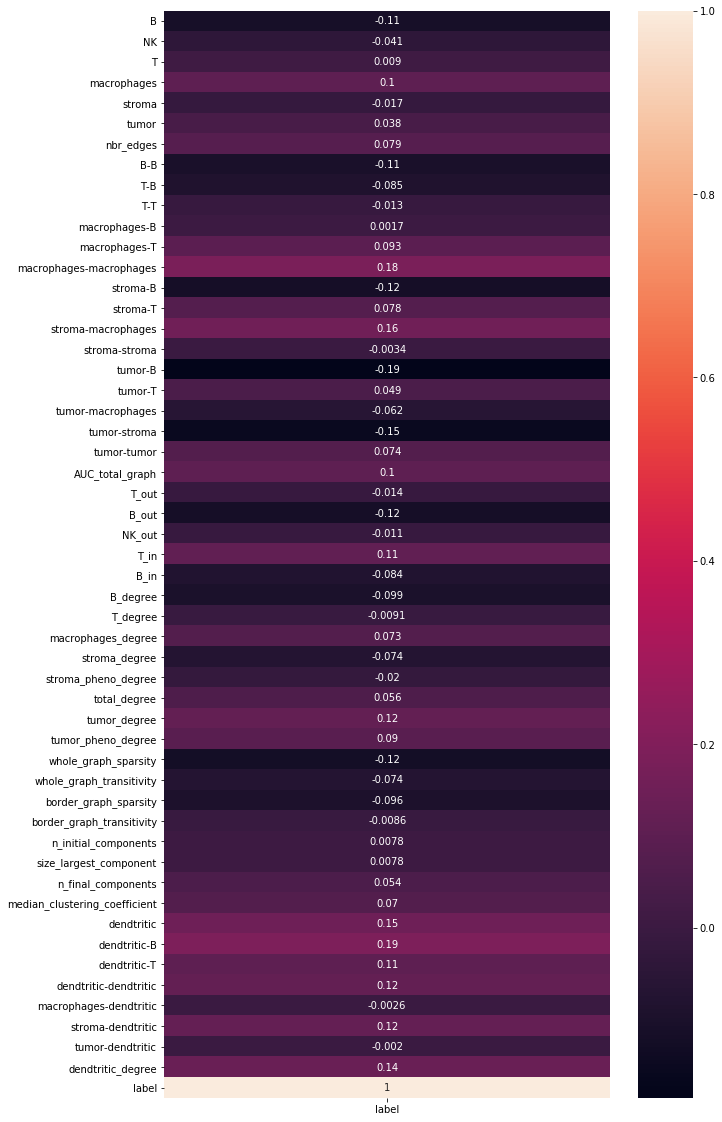

In [114]:
correlation_nodes = nodes_features.corr()
f, ax = plt.subplots(figsize=(10, 20))
ax = sns.heatmap(correlation_nodes.iloc[:,52:],annot=True)

if (INCLUDE_DR == False) and (N_CLASSES == 2):
    plt.savefig(PLOT_DIRECTORY + 'nodes_features_correlation_label.png')

if (INCLUDE_DR == True) and (N_CLASSES == 2):
    plt.savefig(PLOT_DIRECTORY + '2_class_DR_nodes_features_correlation_label.png')


In [115]:
correlation_nodes = nodes_features.corr()
f, ax = plt.subplots(figsize=(15, 15))
ax = sns.heatmap(correlation_nodes.iloc[:,:])
if (INCLUDE_DR == False) and (N_CLASSES == 2):
    plt.savefig(PLOT_DIRECTORY + 'nodes_features_correlation.png' )

if (INCLUDE_DR == True) and (N_CLASSES == 2):
    plt.savefig(PLOT_DIRECTORY + '2_classes_DR_nodes_features_correlation.png', )

plt.close()

## Kendall correlation

In [116]:
label = nodes_features.label.values
nodes_columns_ = nodes_features.columns[1:]
kendall_corr ={}
for column in nodes_columns_:
    column_value = nodes_features[column].values
    kendall_corr[column] = scipy.stats.kendalltau(column_value, label).correlation

kendall_corr = pd.DataFrame(kendall_corr, index = [0])
kendall_corr = pd.melt(kendall_corr).set_index(['variable'])
f, ax = plt.subplots(figsize=(10, 20))
ax = sns.heatmap(kendall_corr,annot=True)


if (INCLUDE_DR == False) and (N_CLASSES == 2):
    plt.savefig(PLOT_DIRECTORY + 'nodes_kendall_tau.png')


if (INCLUDE_DR == True) and (N_CLASSES == 2):
    plt.savefig(PLOT_DIRECTORY + '2_classes_DR_nodes_kendall_tau.png')


plt.close()


## Spearman Tau 

In [117]:
label = nodes_features.label.values
nodes_columns_ = nodes_features.columns[1:]
spearmanr_corr ={}


for column in nodes_columns_:
    column_value = nodes_features[column].values
    spearmanr_corr[column] = scipy.stats.spearmanr(column_value, label).correlation

    
spearmanr_corr = pd.DataFrame(spearmanr_corr, index = [0])
spearmanr_corr = pd.melt(spearmanr_corr).set_index(['variable'])
f, ax = plt.subplots(figsize=(10, 20))
ax = sns.heatmap(spearmanr_corr,annot=True)

if (INCLUDE_DR == False) and (N_CLASSES == 2):
    plt.savefig(PLOT_DIRECTORY + 'nodes_spearman_rho.png')


if (INCLUDE_DR == True) and (N_CLASSES == 2):
    plt.savefig(PLOT_DIRECTORY + '2_classes_DR_nodes_spearman_rho.png')


plt.close()


In [118]:
label = nodes_features.label.values
nodes_columns_ = nodes_features.columns[1:]
kendall_corr ={}
for column in nodes_columns_:
    column_value = nodes_features[column].values
    kendall_corr[column] = scipy.stats.kendalltau(column_value, label).correlation

kendall_corr = pd.DataFrame(kendall_corr, index = [0])
kendall_corr = pd.melt(kendall_corr).set_index(['variable'])
f, ax = plt.subplots(figsize=(10, 20))
ax = sns.heatmap(kendall_corr,annot=True)
plt.close()

# Clustering 

## K-means clustering

In [119]:
N_CLUSTER = 2
X = nodes_features.iloc[:,1:53]
y = nodes_features.label.values
kmeans = KMeans(n_clusters=N_CLUSTER, random_state=0).fit(X)
predicted_label = kmeans.labels_

In [120]:
predicted_label

array([1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1],
      dtype=int32)

In [121]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0])

In [122]:
distance.hamming(predicted_label, y)

0.6507936507936508

In [123]:
confusion_matrix(y,predicted_label)

array([[14, 35],
       [ 6,  8]])

## Hierarchical clustering

### Ward

In [124]:
clustering = AgglomerativeClustering(linkage = 'ward').fit(X)
hierarchical_label = clustering.labels_
hierarchical_label

array([0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [125]:
distance.hamming(hierarchical_label, y)

0.36507936507936506

In [126]:
confusion_matrix(y,hierarchical_label)

array([[35, 14],
       [ 9,  5]])

### Complete

In [127]:
clustering = AgglomerativeClustering(linkage = 'complete').fit(X)
hierarchical_complete_label = clustering.labels_

In [128]:
hierarchical_complete_label = list(map(lambda x : 1 if(x==0)  else 0, hierarchical_complete_label))

In [129]:
confusion_matrix(y,hierarchical_complete_label)

array([[35, 14],
       [ 9,  5]])

# Principal component analysis 

In [130]:
pca = PCA(n_components=3)
label = nodes_features.label.values
features_scaled= nodes_features.drop(['name','label'],axis=1)
principalComponents = pca.fit_transform(features_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
principalDf['label'] = label

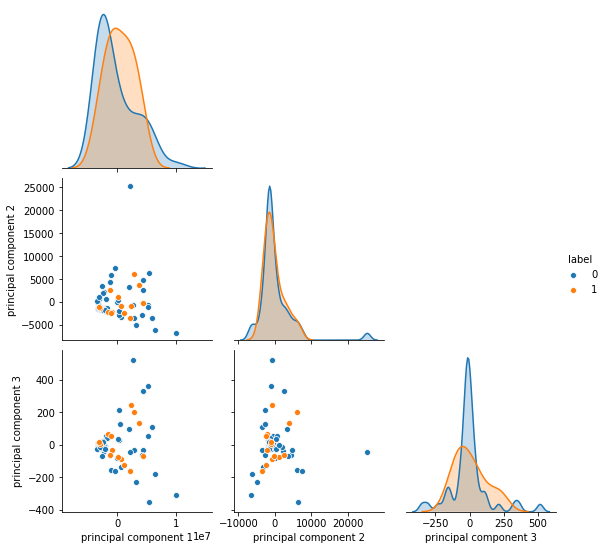

In [131]:
if (INCLUDE_DR == False) and (N_CLASSES == 2):
    sns.pairplot(principalDf, hue='label', corner =True).savefig(PLOT_DIRECTORY+'nodes_features_PCA.png')



if (INCLUDE_DR == True) and (N_CLASSES == 2):
    sns.pairplot(principalDf, hue='label', corner =True).savefig(PLOT_DIRECTORY+'2_classes_DR_nodes_features_PCA.png')



In [132]:
pca.explained_variance_ratio_

array([9.99998153e-01, 1.84497235e-06, 1.89227358e-09])

# Canonical Correlation analysis

In [133]:
X = nodes_features.iloc[:,1:53]
Y = nodes_features.label.values

In [134]:
ca = CCA()
ca.fit(X, Y)
X_c, Y_c = ca.transform(X, Y)

print(X_c.shape)
print(Y_c.shape)

(63, 2)
(63,)


Y residual constant at iteration 1


In [135]:
np.corrcoef(X_c[:,0], Y_c[:])

array([[1.        , 0.94313866],
       [0.94313866, 1.        ]])

# Checking separability

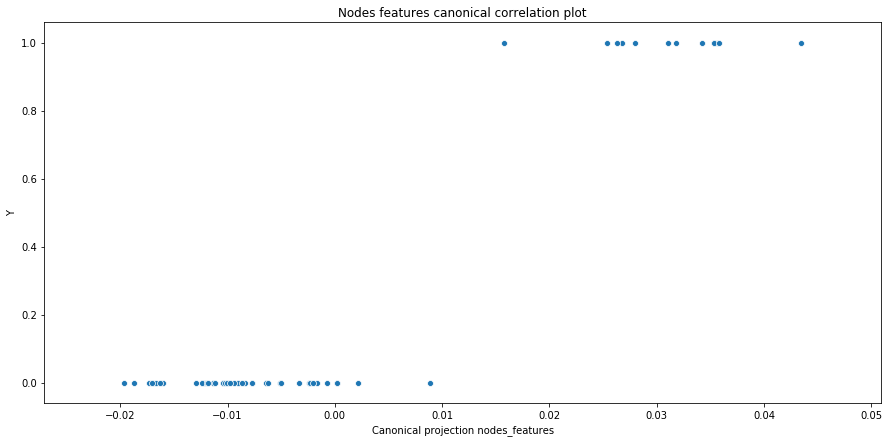

In [136]:
X_c_1 = [x[0] for x in X_c]
plt.figure(figsize=(15,7))
sns.scatterplot(X_c_1,Y)
plt.xlabel('Canonical projection nodes_features')
plt.ylabel('Y')
plt.title('Nodes features canonical correlation plot')
plt.savefig(PLOT_DIRECTORY + 'canonical_correlation_all_nodes_features.png')

### Fitting a 1D classifier

In [137]:
X_c_1 = np.array(X_c_1).reshape(-1,1)

In [138]:
clf = svm.SVC(kernel ='rbf' , class_weight='balanced')

clf.fit(X_c_1,Y)
y_pred = clf.predict(X_c_1)
confusion_matrix(Y,y_pred)

array([[48,  1],
       [ 0, 14]])

### Checking CCA independently using set of columns
#### Merging nodes_features to region cells densities

In [139]:
densities = region_nodes_counts.drop(['label'],axis =1)
coef = clus_coef_df.drop(['label'],axis =1)

nodes_features_merged = nodes_features.merge(densities, on ='name', how = 'inner')
nodes_features_merged = nodes_features_merged.merge(coef,on ='name', how = 'inner')

In [140]:
list_columns_sets = list(nodes_columns.keys())
canonical_correlation = []

for column_set in list_columns_sets:
     
    columns_values = nodes_columns[column_set]
    n = len(columns_values)
    restricted_data = nodes_features_merged[columns_values]
    X = restricted_data.iloc[:,1:n-1]
    Y = restricted_data.label.values
    ca = CCA()
    ca.fit(X, Y)
    X_c, Y_c = ca.transform(X, Y)
    cca = np.corrcoef(X_c[:, 0], Y_c[:, ])[0,1]
    canonical_correlation.append(cca)

Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1


Text(0.5, 1.0, 'Canonical correlation per set of columns')

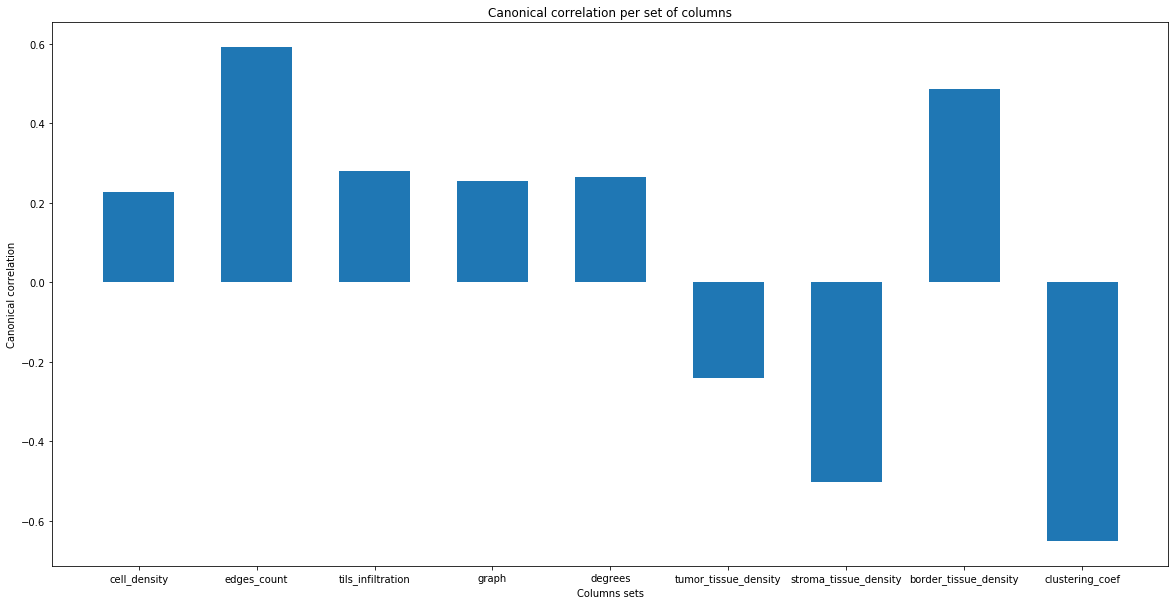

In [141]:
plt.figure(figsize=(20,10))

plt.bar(list_columns_sets, canonical_correlation, width = 0.6)
plt.xlabel('Columns sets')
plt.ylabel('Canonical correlation')
plt.title('Canonical correlation per set of columns')
#plt.savefig(PLOT_DIRECTORY + 'Canonical correlation per set of columns.png')

# Fitting classifiers

## All data as training

In [142]:
X = nodes_features.iloc[:,1:53]
y = nodes_features.label.values

### SVM: POLY

In [143]:
if N_CLASSES == 2:
    clf = svm.SVC(kernel ='poly', degree =1,class_weight ='balanced')
if N_CLASSES == 3:
    clf = OneVsRestClassifier(svm.SVC(kernel ='poly', degree =4,class_weight ='balanced'))

clf.fit(X,y)
y_pred = clf.predict(X)
confusion_matrix(y,y_pred)

array([[34, 15],
       [ 7,  7]])

### SVM: RBF

In [144]:
if N_CLASSES == 2:
    clf = svm.SVC(kernel ='rbf',class_weight ='balanced')
    
if N_CLASSES == 3:
    clf = OneVsRestClassifier(svm.SVC(kernel ='rbf',class_weight ='balanced'))

clf.fit(X,y)
y_pred = clf.predict(X)
confusion_matrix(y,y_pred)

array([[32, 17],
       [ 3, 11]])

### Logistic regression

In [145]:
if N_CLASSES == 2:
    clf = LogisticRegression(random_state=0)

if N_CLASSES == 3:
    clf = OneVsRestClassifier(clf = LogisticRegression(random_state=0))
    
clf.fit(X, y)
y_pred = clf.predict(X)
confusion_matrix(y,y_pred)

array([[49,  0],
       [14,  0]])

### Random forest

In [146]:
if N_CLASSES == 2:
    clf = RandomForestClassifier(max_depth=6, random_state=0)

if N_CLASSES == 3:
    clf = OneVsRestClassifier(clf = RandomForestClassifier(max_depth=6, random_state=0))
    
clf.fit(X, y)
y_pred = clf.predict(X)
confusion_matrix(y,y_pred)

array([[49,  0],
       [ 0, 14]])

## 3 Folds cross validation

iteration: 0
Training Error :
True y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
Predicted y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
[[34  0]
 [ 0 10]]
Testing Error :
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[14  1]
 [ 4  0]]
iteration: 1
Training Error :
True y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
Predicted y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
[[34  0]
 [ 0 10]]
Testing Error :
[0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[12  3]
 [ 4  0]]
iteration: 2
Training Error :
True y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
Predicted y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 

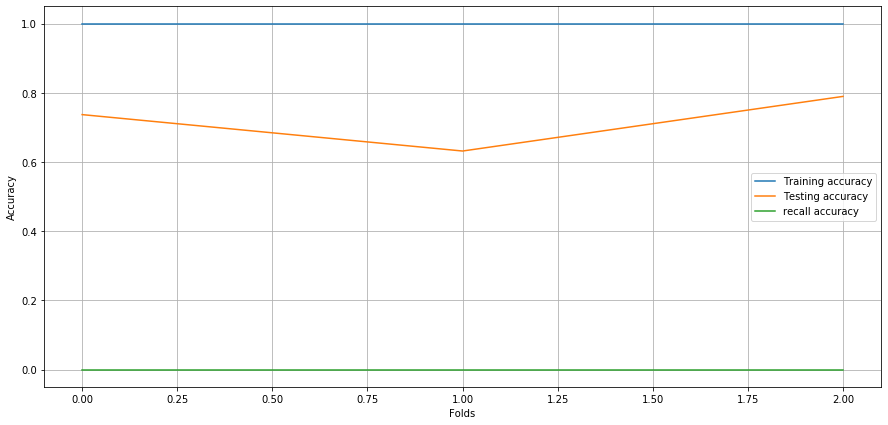

In [147]:
fit_model(nodes_features,'nodes_features','forest',3,2,30)

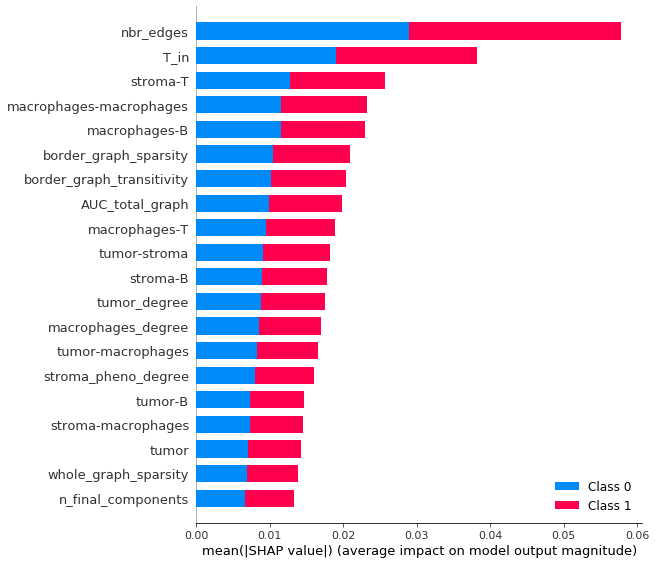

In [148]:
shap.initjs()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

In [149]:
columns_to_plot =['tumor-stroma','label']
plot_histo = nodes_features[columns_to_plot]
ax = sns.pairplot(plot_histo, hue='label',height =10)
plt.savefig(PLOT_DIRECTORY +'nodes_tumor-stroma.png')
plt.close()

In [150]:
columns_to_plot =['whole_graph_transitivity','label']
plot_histo = nodes_features[columns_to_plot]
ax = sns.pairplot(plot_histo, hue='label',height =10)
plt.savefig(PLOT_DIRECTORY +'nodes_whole_graph_transitivity.png')
plt.close()

# Laplace Quadtratic features

## Correlation analysis

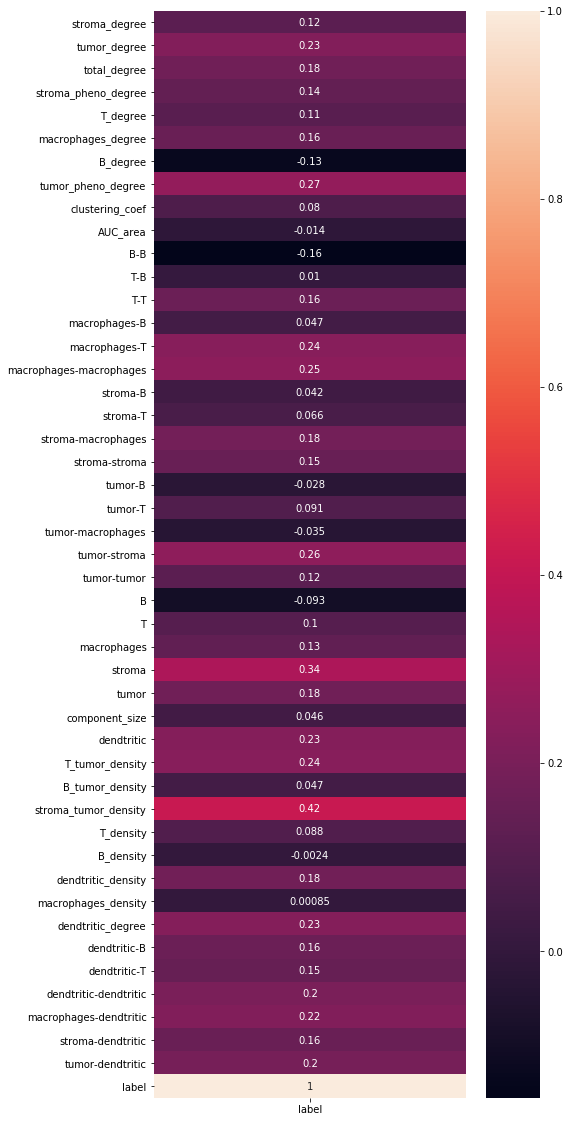

In [151]:
correlation_nodes = laplace_quadratics_features.corr()
f, ax = plt.subplots(figsize=(7, 20))
ax = sns.heatmap(correlation_nodes.iloc[:,46:],annot=True)
if (INCLUDE_DR == False) and (N_CLASSES == 2):
    plt.savefig(PLOT_DIRECTORY + 'laplace_correlation_label.png')

if (INCLUDE_DR == True) and (N_CLASSES == 2):
    plt.savefig(PLOT_DIRECTORY + '2_classes_DR_laplace_correlation_label.png')



In [152]:
correlation_nodes = laplace_quadratics_features.corr()
f, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(correlation_nodes.iloc[:,:],annot=False)
plt.savefig(PLOT_DIRECTORY + 'laplace_correlation.png')
plt.close()

## Kendall tau

In [153]:
label = laplace_quadratics_features.label.values
laplace_columns_ = laplace_quadratics_features.columns[1:]
kendall_corr ={}
for column in laplace_columns_:
    if column != 'name' :
        column_value = laplace_quadratics_features[column].values
        kendall_corr[column] = scipy.stats.kendalltau(column_value, label).correlation

kendall_corr = pd.DataFrame(kendall_corr, index = [0])
kendall_corr = pd.melt(kendall_corr).set_index(['variable'])
f, ax = plt.subplots(figsize=(10, 20))
ax = sns.heatmap(kendall_corr,annot=True)
plt.savefig(PLOT_DIRECTORY + 'label_kendall_tau.png')
plt.close()

## Spearmann rho 

In [154]:
label = laplace_quadratics_features.label.values
nodes_columns_ = laplace_quadratics_features.columns[1:]
spearmanr_corr ={}


for column in nodes_columns_:
    if column != 'name' :
        column_value = laplace_quadratics_features[column].values
        spearmanr_corr[column] = scipy.stats.spearmanr(column_value, label).correlation

    
spearmanr_corr = pd.DataFrame(spearmanr_corr, index = [0])
spearmanr_corr = pd.melt(spearmanr_corr).set_index(['variable'])
f, ax = plt.subplots(figsize=(10, 20))
ax = sns.heatmap(spearmanr_corr,annot=True)
plt.savefig(PLOT_DIRECTORY + 'laplace_spearman_rho.png')
plt.close()

In [155]:
correlation_nodes = laplace_quadratics_features.corr()
f, ax = plt.subplots(figsize=(15, 15))
ax = sns.heatmap(correlation_nodes.iloc[:,:])
plt.savefig(PLOT_DIRECTORY + 'laplace_correlation.png')
plt.close()

## Principal component analysis

In [156]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
label = laplace_quadratics_features.label.values
features_scaled= laplace_quadratics_features.drop(['name','label'],axis=1)
principalComponents = pca.fit_transform(features_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
principalDf['label'] = label

In [157]:
sns.pairplot(principalDf, hue='label', corner =True).savefig(PLOT_DIRECTORY+'Laplace_PCA.png')
plt.close()

In [158]:
pca.explained_variance_ratio_

array([0.61988126, 0.0875994 , 0.06873013])

# Canonical correlation analysis

In [159]:
X = laplace_quadratics_features.iloc[:,1:47]
Y = laplace_quadratics_features.label.values

In [160]:
ca = CCA()
ca.fit(X, Y)
X_c, Y_c = ca.transform(X, Y)

print(X_c.shape)
print(Y_c.shape)

(63, 2)
(63,)


Y residual constant at iteration 1


In [161]:
np.corrcoef(X_c[:, 0], Y_c[:, ])[0,1]

0.9372098837533936

### Checking separability

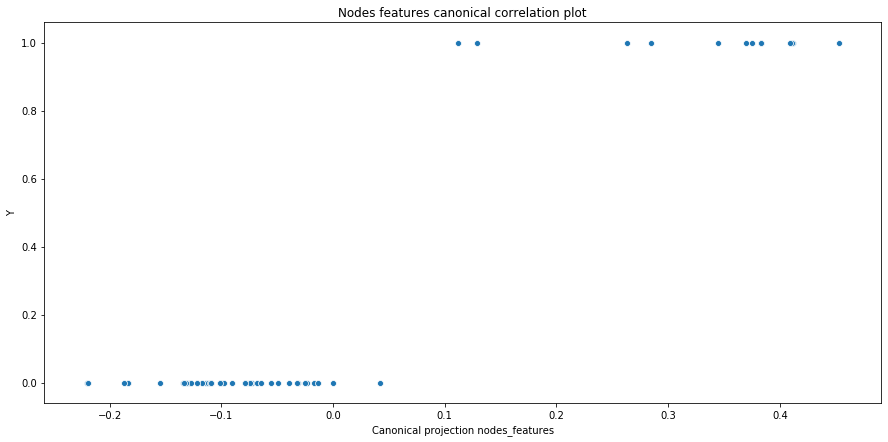

In [162]:
X_c_1 = [x[0] for x in X_c]
plt.figure(figsize=(15,7))
sns.scatterplot(X_c_1,Y)
plt.xlabel('Canonical projection nodes_features')
plt.ylabel('Y')
plt.title('Nodes features canonical correlation plot')
plt.savefig(PLOT_DIRECTORY + 'canonical_correlation_all_nodes_features.png')

### Fitting a 1D classifier

In [163]:
X_c_1 = np.array(X_c_1).reshape(-1,1)

In [164]:
clf = svm.SVC(kernel ='rbf' , class_weight='balanced')

clf.fit(X_c_1,Y)
y_pred = clf.predict(X_c_1)
confusion_matrix(Y,y_pred)

array([[49,  0],
       [ 0, 14]])

### Checking CCA independently using set of columns
#### Merging nodes_features to region cells densities

In [165]:
list_columns_sets = list(laplace_columns.keys())
canonical_correlation = []
training_accuracy = []

for column_set in list_columns_sets:
    
    columns_values = laplace_columns[column_set]
    n = len(columns_values)
    restricted_data = laplace_quadratics_features[columns_values]
    X = restricted_data.iloc[:,1:n-1]
    Y = restricted_data.label.values
    ca = CCA()
    ca.fit(X, Y)
    X_c, Y_c = ca.transform(X, Y)
    cca = np.corrcoef(X_c[:, 0], Y_c[:, ])[0,1]
    
    X_c_1 = np.array(X_c_1).reshape(-1,1)
    clf =  LogisticRegression(random_state=0,class_weight = {0:1,1:20})
    clf.fit(X_c_1,Y)
    
    
    training_accuracy.append(clf.score(X_c_1,Y))
    
    
    canonical_correlation.append(cca)

Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1
Y residual constant at iteration 1


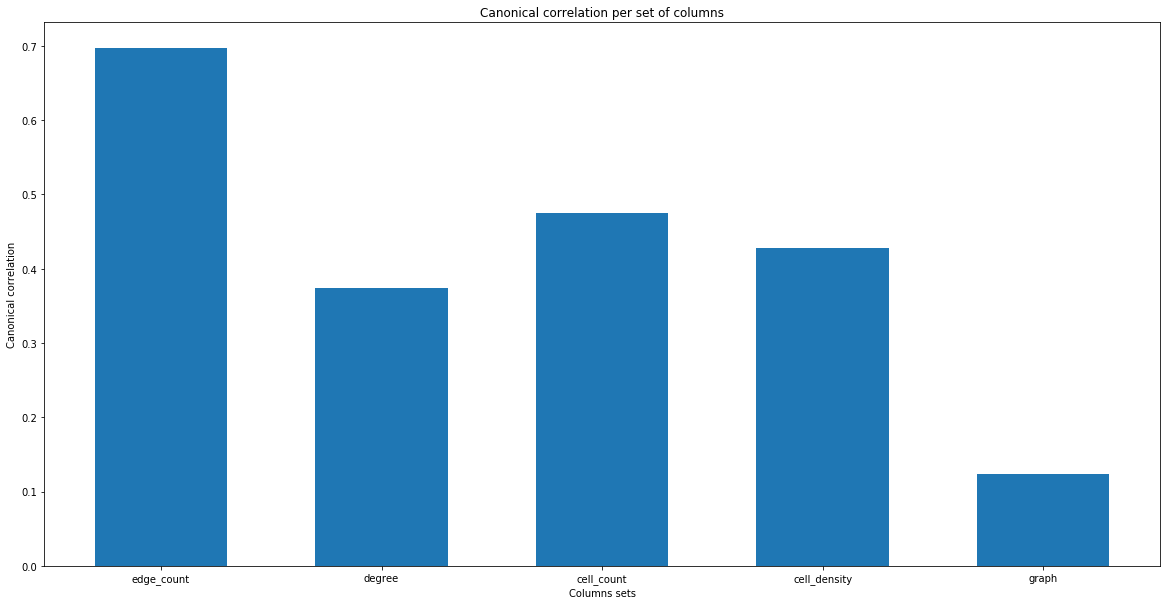

In [166]:
plt.figure(figsize=(20,10))

plt.bar(list_columns_sets, canonical_correlation, width = 0.6)
plt.xlabel('Columns sets')
plt.ylabel('Canonical correlation')
plt.title('Canonical correlation per set of columns')
plt.savefig(PLOT_DIRECTORY + 'Laplace quadtratic Canonical correlation per set of columns.png')

Text(0.5, 1.0, 'Canonical correlation per set of columns')

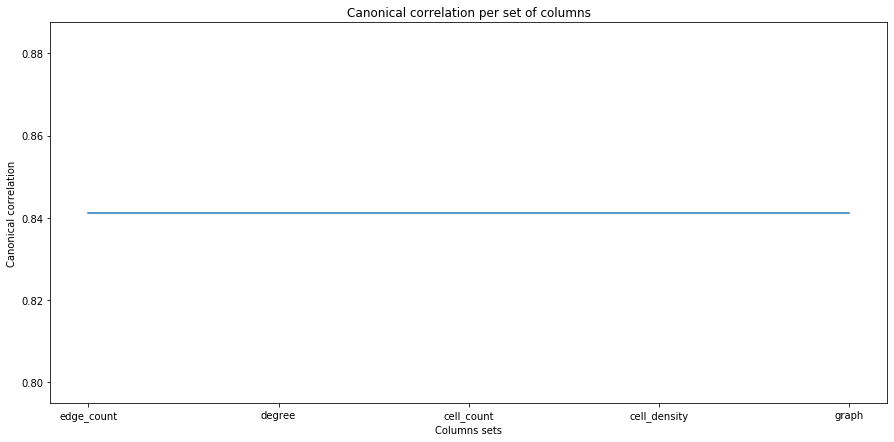

In [167]:
plt.figure(figsize=(15,7))

plt.plot(list_columns_sets, training_accuracy)
plt.xlabel('Columns sets')
plt.ylabel('Canonical correlation')
plt.title('Canonical correlation per set of columns')


# Fitting classifiers

## All data as training

In [168]:
X = laplace_quadratics_features.iloc[:,1:47]
y = laplace_quadratics_features.label.values

### SVM: POLY

In [169]:
if N_CLASSES == 2:
    clf = svm.SVC(kernel ='poly', degree =1,class_weight ='balanced')
if N_CLASSES == 3:
    clf = OneVsRestClassifier(svm.SVC(kernel ='poly', degree =1,class_weight ='balanced'))

clf.fit(X,y)
y_pred = clf.predict(X)
confusion_matrix(y,y_pred)

array([[46,  3],
       [ 8,  6]])

### SVM: RBF

In [170]:
if N_CLASSES == 2:
    clf = svm.SVC(kernel ='rbf',class_weight ='balanced')
    
if N_CLASSES == 3:
    clf = OneVsRestClassifier(svm.SVC(kernel ='rbf',class_weight ='balanced'))

clf.fit(X,y)
y_pred = clf.predict(X)
confusion_matrix(y,y_pred)

array([[48,  1],
       [ 5,  9]])

### Logistic regression

In [171]:
if N_CLASSES == 2:
    clf = LogisticRegression(random_state=0,class_weight ='balanced')

if N_CLASSES == 3:
    clf = OneVsRestClassifier(clf = LogisticRegression(random_state=0,class_weight ='balanced'))
    
clf.fit(X, y)
y_pred = clf.predict(X)
confusion_matrix(y,y_pred)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


array([[49,  0],
       [ 0, 14]])

### Random forest

In [172]:
if N_CLASSES == 2:
    clf = RandomForestClassifier(max_depth=6, random_state=0,class_weight ='balanced')

if N_CLASSES == 3:
    clf = OneVsRestClassifier(clf = RandomForestClassifier(max_depth=6, random_state=0))
    
clf.fit(X, y)
y_pred = clf.predict(X)
confusion_matrix(y,y_pred)

array([[49,  0],
       [ 0, 14]])

## 3 Folds cross validation

iteration: 0
Training Error :
True y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
Predicted y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
[[34  0]
 [ 0 10]]
Testing Error :
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[15  0]
 [ 4  0]]
iteration: 1
Training Error :
True y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
Predicted y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
[[34  0]
 [ 0 10]]
Testing Error :
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[14  1]
 [ 4  0]]
iteration: 2
Training Error :
True y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
Predicted y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 

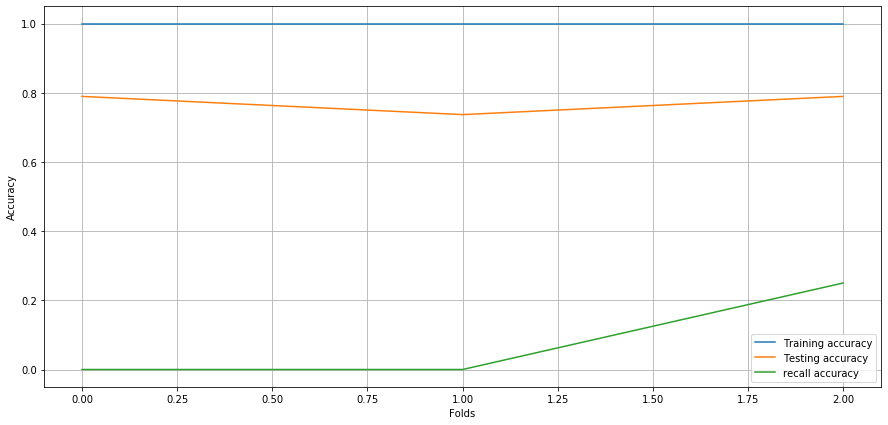

In [173]:
fit_model(laplace_quadratics_features,'laplace_quadtratic_features','forest',3,2,20)

## Feature importance

In [174]:
model = RandomForestClassifier(max_depth=10, criterion= 'gini',random_state=0, class_weight={0:1,1:20} )
model.fit(X, y)
y_pred = model.predict(X)
confusion_matrix(y,y_pred)

array([[49,  0],
       [ 0, 14]])

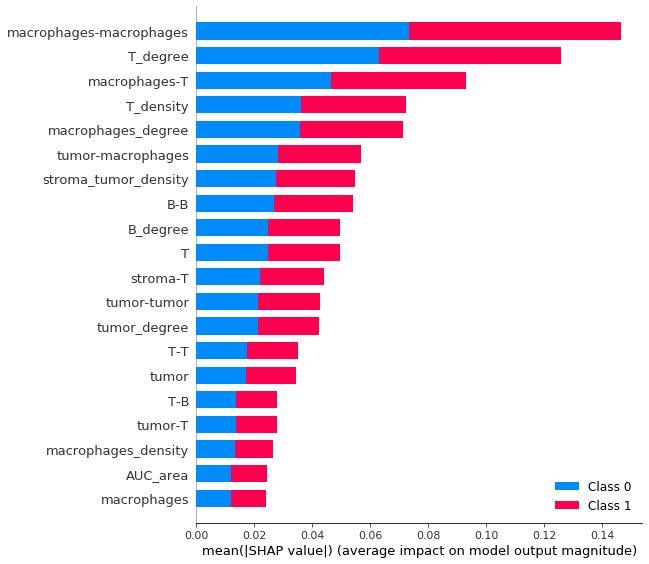

In [175]:
shap.initjs()
f, ax = plt.subplots(figsize=(15, 15))

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, features=X, feature_names=X.columns)


# Checking best class weights

In [233]:
recall_scores = []

data = laplace_quadratics_features
data = data.reset_index()
data = data.drop(['index'], axis = 1)

index_class_1 = list(data[data.label == 1].index)
index_class_0 = list(data[data.label == 0].index)



weights = [1,2,3,5,10,15,20,30]

weights_mean_training_error = []
weights_mean_testing_error = []
weights_mean_recall_error = []

MODEL = 'logistic'


for weight in weights :
    print('Class 1 weight: ',weight)
    training_error =[]
    testing_error = []
    testing_recall =[]
    for iteration in range(3):
        print('iteration:', iteration)
        
        if MODEL == 'logistic':
            clf = SGDClassifier(loss = 'log', max_iter=1000 ,tol=1e-3, shuffle = True, learning_rate = 'adaptive',eta0=5, class_weight={0:1,1:weight},validation_fraction = 0.01)
            
        if MODEL == 'hinge':
            clf = SGDClassifier(loss = 'hinge', max_iter=1000, tol=1e-3, shuffle = True, learning_rate = 'adaptive',eta0=5, class_weight ={0:1,1:weight},validation_fraction = 0.01)
            
        if MODEL == 'rbf' :  
            clf = svm.SVC(C= 1, kernel ='rbf',class_weight={0:1,1:weight})
            
        if MODEL == 'polynomial':     
            clf = svm.SVC(C= 1, kernel ='poly',class_weight={0:1,1:weight})
            
        if MODEL == 'forest'  :
            clf ==  RandomForestClassifier(max_depth=6, random_state=0,class_weight={0:1,1:weight})

            
            
        train_indicies_class_1 , test_indicies_class_1 =  shuffle_and_pick(index_class_1, 10)
        train_indicies_class_0 , test_indicies_class_0 =  shuffle_and_pick(index_class_0, 30)


        train_indicies = train_indicies_class_1 + train_indicies_class_0
        test_indicies = test_indicies_class_1 + test_indicies_class_0

        X_train =data.iloc[train_indicies,1:51]
        y_train = data.label.values[train_indicies]

        X_test =data.iloc[test_indicies,1:51]
        y_test = data.label.values[test_indicies]


        clf.fit(X_train,y_train)
        print('Training Error :')
        y_hat_train = clf.predict(X_train)
        print('True y_train :', y_train)
        print('Predicted y_train :', y_hat_train)
        recall_score_ = recall_score(y_train, y_hat_train)
        print(confusion_matrix(y_train, y_hat_train))
        print('Training recall class 1 : ', recall_score_)
        training_error.append(clf.score(X_train,y_train))
    
    
        print('Training Error :')

        y_hat = clf.predict(X_test)
        print(y_hat)
        print(y_test)
        recall_score_ = recall_score(y_test, y_hat)
        print('recall class 1 : ', recall_score_)
        print(confusion_matrix(y_test, y_hat))
        recall_scores.append(recall_score_)
        testing_error.append(clf.score(X_test,y_test))
        
    weights_mean_training_error.append(np.mean(training_error))  
    weights_mean_testing_error.append(np.mean(testing_error))
    weights_mean_recall_error.append(np.mean(recall_scores))


Class 1 weight:  1
iteration: 0
Training Error :
True y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Predicted y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[[30  0]
 [ 0 10]]
Training recall class 1 :  1.0
Training Error :
[1 0 1 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0]
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
recall class 1 :  0.5
[[13  6]
 [ 2  2]]
iteration: 1
Training Error :
True y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Predicted y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[[30  0]
 [ 0 10]]
Training recall class 1 :  1.0
Training Error :
[1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1]
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
recall class 1 :  0.75
[[14  5]
 [ 1  3]]
iteration: 2
Training Error :
True y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



[0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
recall class 1 :  0.5
[[17  2]
 [ 2  2]]
iteration: 2
Training Error :
True y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Predicted y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[[29  1]
 [ 0 10]]
Training recall class 1 :  1.0
Training Error :
[0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1]
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
recall class 1 :  0.5
[[15  4]
 [ 2  2]]
Class 1 weight:  30
iteration: 0
Training Error :
True y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Predicted y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0
 0 0 1]
[[22  8]
 [ 0 10]]
Training recall class 1 :  1.0
Training Error :
[1 1 1 1 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1]
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
recall class 

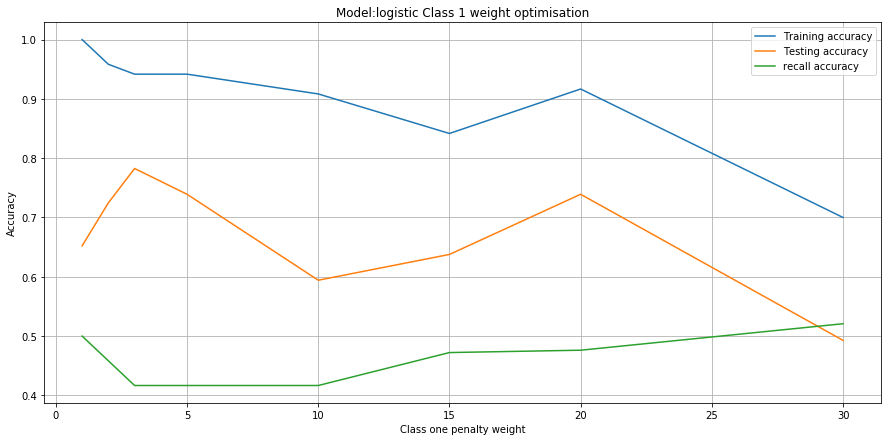

In [234]:
plt.figure(figsize=(15,7))

plt.plot(weights,weights_mean_training_error, label = 'Training accuracy'  )
plt.plot(weights,weights_mean_testing_error, label = 'Testing accuracy'  )
plt.plot(weights,weights_mean_recall_error, label = 'recall accuracy'  )

plt.xlabel('Class one penalty weight')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.title('Model:'+ MODEL + ' Class 1 weight optimisation' )
plt.savefig(PLOT_DIRECTORY + MODEL +'class_one_weight_optimisation.png')

# Analysing subset  :  Nodes Edge count

In [178]:
edge_count_columns = nodes_columns['edges_count']

In [179]:
edge_count_df = nodes_features[edge_count_columns]
n = len(edge_count_df.columns)

In [180]:
X = edge_count_df.iloc[:,1:n-1]
Y = edge_count_df.label.values


ca = CCA()
ca.fit(X, Y)
X_c, Y_c = ca.transform(X, Y)

print(X_c.shape)
print(Y_c.shape)


(63, 2)
(63,)


Y residual constant at iteration 1


In [181]:
np.corrcoef(X_c[:, 0], Y_c[:, ])

array([[1.        , 0.59240483],
       [0.59240483, 1.        ]])

In [182]:
weight =3
model = RandomForestClassifier(max_depth=20, random_state=0,class_weight={0:1,1:weight})
model.fit(X,Y)
y_pred = model.predict(X)
confusion_matrix(Y,y_pred)

array([[49,  0],
       [ 0, 14]])

In [183]:
#X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=42)
#model = RandomForestClassifier(max_depth=9, random_state=0)
#model.fit(X_train, y_train)
#y_pred = model.predict(X_test)
#confusion_matrix(y_test,y_pred)

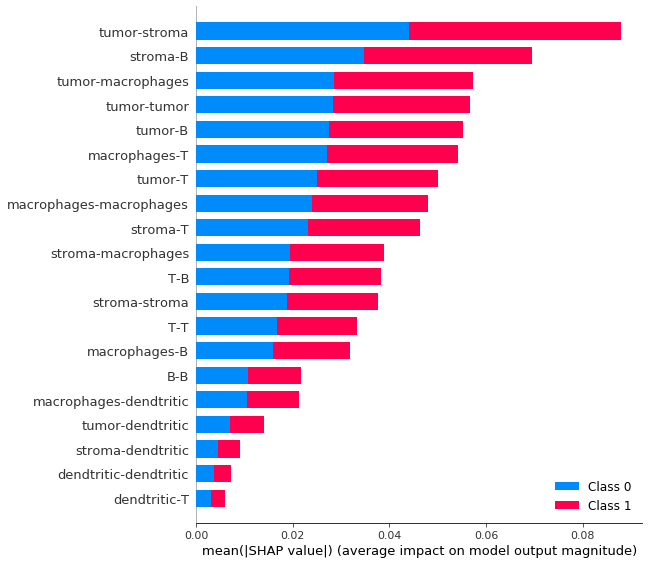

<Figure size 432x288 with 0 Axes>

In [184]:
shap.initjs()
f, ax = plt.subplots(figsize=(15, 15))
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, features=X, feature_names=X.columns)
plt.savefig(PLOT_DIRECTORY + 'edge_count_feature_importance.png')

# Analysing subset  :  Laplace Edge count

In [185]:
laplace_edge_count_columns = laplace_columns['edge_count']

In [186]:
laplace_edge_count_df = laplace_quadratics_features[laplace_edge_count_columns]
n = len(laplace_edge_count_df.columns)

In [187]:
X = laplace_edge_count_df.iloc[:,1:n-1]
Y = laplace_edge_count_df.label.values

In [188]:
weight =20
model = RandomForestClassifier(max_depth=10, random_state=0,class_weight={0:1,1:weight})
model.fit(X,y)
y_pred = model.predict(X)
confusion_matrix(y,y_pred)

array([[49,  0],
       [ 0, 14]])

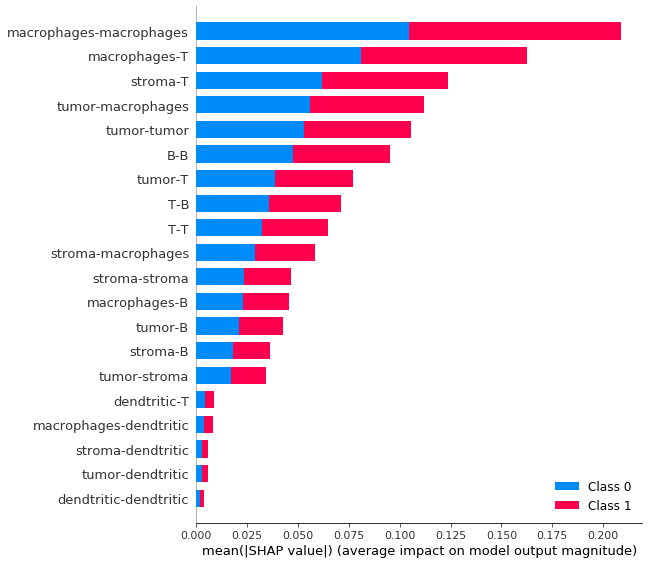

In [189]:
shap.initjs()
f, ax = plt.subplots(figsize=(15, 15))
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, features=X, feature_names=X.columns)


# Nodes region counts:

In [190]:
tumor_region = region_nodes_counts[tumor_tissue_density_columns]
stroma_region = region_nodes_counts[tumor_tissue_density_columns]
border_region = region_nodes_counts[tumor_tissue_density_columns]

## Nodes region count analysis

In [191]:
#sns.pairplot(region_nodes_counts[columns_to_plot],hue='label',corner=True, height = 5)

In [192]:
correlation_nodes = region_nodes_counts.corr()
f, ax = plt.subplots(figsize=(10, 20))
ax = sns.heatmap(correlation_nodes.iloc[:,26:],annot=True)
plt.savefig(PLOT_DIRECTORY + 'nodes_region_count_corr_label.png')
plt.close()

In [193]:
region_nodes_counts = region_nodes_counts[region_nodes_counts.label!=-1]

## Canonical correlation analysis

In [194]:
X = region_nodes_counts[list(region_nodes_counts.columns[1:25])]
Y = region_nodes_counts[['label']].values

In [195]:
from sklearn.cross_decomposition import CCA

ca = CCA()
ca.fit(X, Y)
X_c, Y_c = ca.transform(X, Y)

print(X_c.shape)
print(Y_c.shape)

(63, 2)
(63,)


Y residual constant at iteration 1


In [196]:
np.corrcoef(X_c[:, 0], Y_c[:, ])

array([[ 1.        , -0.68614433],
       [-0.68614433,  1.        ]])

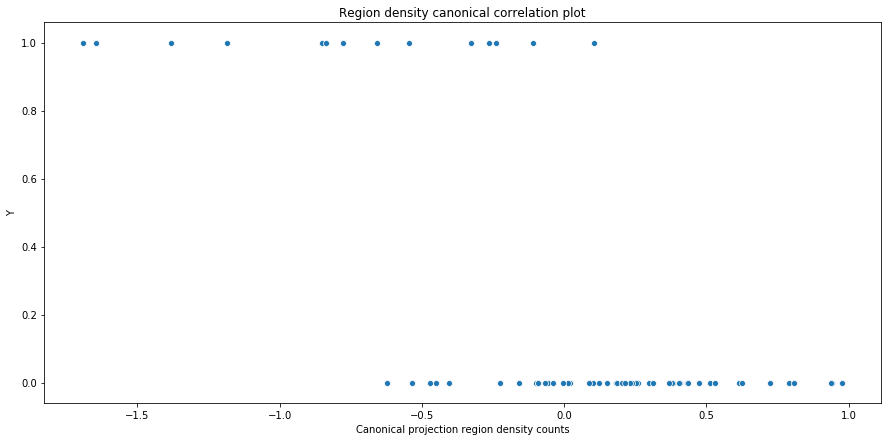

In [197]:
X_c_1 = [x[0] for x in X_c]
Y_c_1 = [y[0] for y in Y]
plt.figure(figsize=(15,7))
sns.scatterplot(X_c_1,Y_c_1)
plt.xlabel('Canonical projection region density counts')
plt.ylabel('Y')
plt.title('Region density canonical correlation plot')
plt.savefig(PLOT_DIRECTORY + 'canonical_correlation_region_density_projection.png')

In [198]:
X_c_1 = np.array(X_c_1).reshape(-1,1)

In [199]:
clf =  LogisticRegression(random_state=0,class_weight='balanced')
clf.fit(X_c_1,Y)
y_pred = clf.predict(X_c_1)
confusion_matrix(Y,y_pred)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


array([[43,  6],
       [ 2, 12]])

In [200]:
edge_count_df = nodes_features[edge_count_columns]

In [201]:
nodes_edge_count = region_nodes_counts.merge(edge_count_df, on ='name', how = 'inner').drop(['label_x'], axis=1).rename(columns={'label_y' : 'label'})
nodes_edge_count.head(3)

,name,border_region_dendtritic,stroma_region_dendtritic,tumor_region_dendtritic,border_region_B,border_region_DP1,border_region_DP2,border_region_T,border_region_macrophages,border_region_stroma,...,tumor-macrophages,tumor-stroma,tumor-tumor,dendtritic-B,dendtritic-T,dendtritic-dendtritic,macrophages-dendtritic,stroma-dendtritic,tumor-dendtritic,label
0,3P1,0.0,0.0,0.0,0.006188,0.000495,0.001114,0.134793,0.016875,0.164879,...,0.015530,0.138992,0.456988,0.0,0.0,0.0,0.0,0.0,0.0,0
1,3F1,0.0,0.0,0.0,0.004923,0.000193,0.000086,0.030569,0.004344,0.215782,...,0.002467,0.130184,0.272253,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1L1,0.0,0.0,0.0,0.001998,0.000011,0.002676,0.026594,0.013636,0.116697,...,0.014374,0.129936,0.321962,0.0,0.0,0.0,0.0,0.0,0.0,0


### Nodes edges count Classification  : 3 folds splits 

iteration: 0
Training Error :
True y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
Predicted y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
[[34  0]
 [ 0 10]]
Testing Error :
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[13  2]
 [ 4  0]]
iteration: 1
Training Error :
True y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
Predicted y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
[[34  0]
 [ 0 10]]
Testing Error :
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[14  1]
 [ 4  0]]
iteration: 2
Training Error :
True y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
Predicted y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 

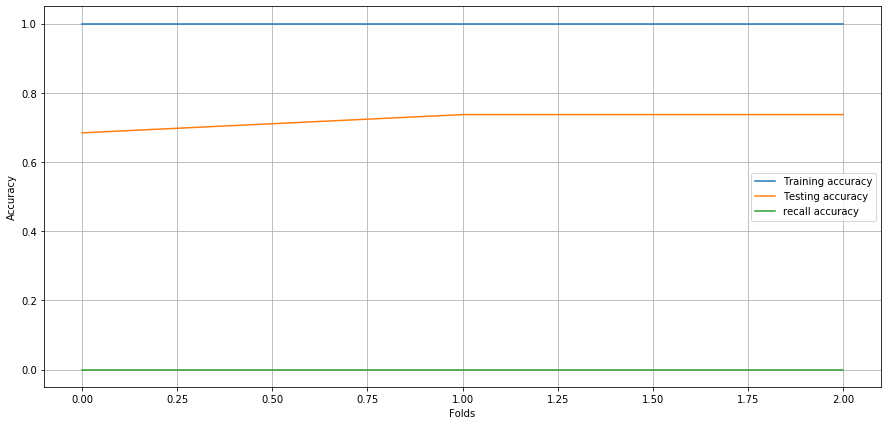

In [202]:
fit_model(nodes_edge_count,'nodes_edge_count','forest',3,2,20)

In [203]:
X = nodes_edge_count[nodes_edge_count.columns[1:48]]
Y = nodes_edge_count[['label']].values

In [204]:
ca = CCA()
ca.fit(X, Y)
X_c, Y_c = ca.transform(X, Y)

print(X_c.shape)
print(Y_c.shape)

(63, 2)
(63,)


Y residual constant at iteration 1


In [205]:
np.corrcoef(X_c[:, 0], Y_c[:, ])

array([[1.        , 0.87550013],
       [0.87550013, 1.        ]])

In [206]:
len(Y)

63

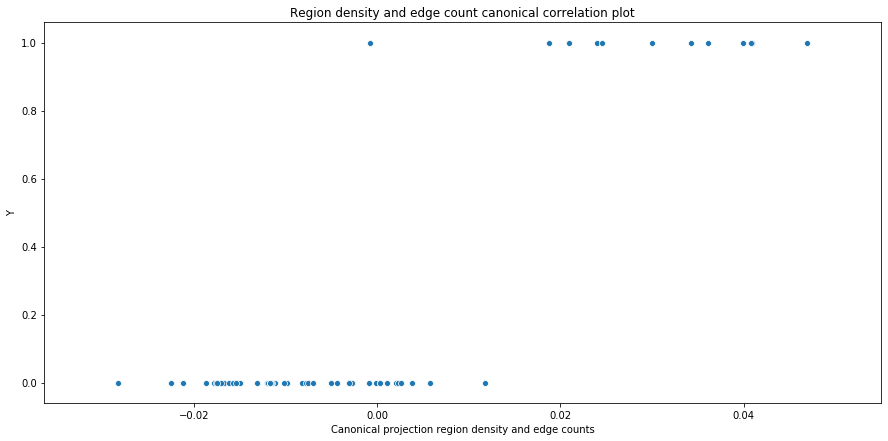

In [207]:
X_c_1 = [x[0] for x in X_c]
Y_c_1 = [y[0] for y in Y]
plt.figure(figsize=(15,7))
sns.scatterplot(X_c_1,Y_c_1)
plt.xlabel('Canonical projection region density and edge counts')
plt.ylabel('Y')
plt.title('Region density and edge count canonical correlation plot')
plt.savefig(PLOT_DIRECTORY + 'canonical_correlation_region_density_and edge_count_projection.png')

In [208]:
X_c_1 = np.array(X_c_1).reshape(-1,1)
clf =  clf = svm.SVC(kernel ='rbf' , class_weight='balanced')

clf.fit(X_c_1,Y)
y_pred = clf.predict(X_c_1)
confusion_matrix(Y,y_pred)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


array([[49,  0],
       [ 1, 13]])

# Clustering coefficient

In [224]:
clus_coef_df = clus_coef_df.drop_duplicates(['name'])

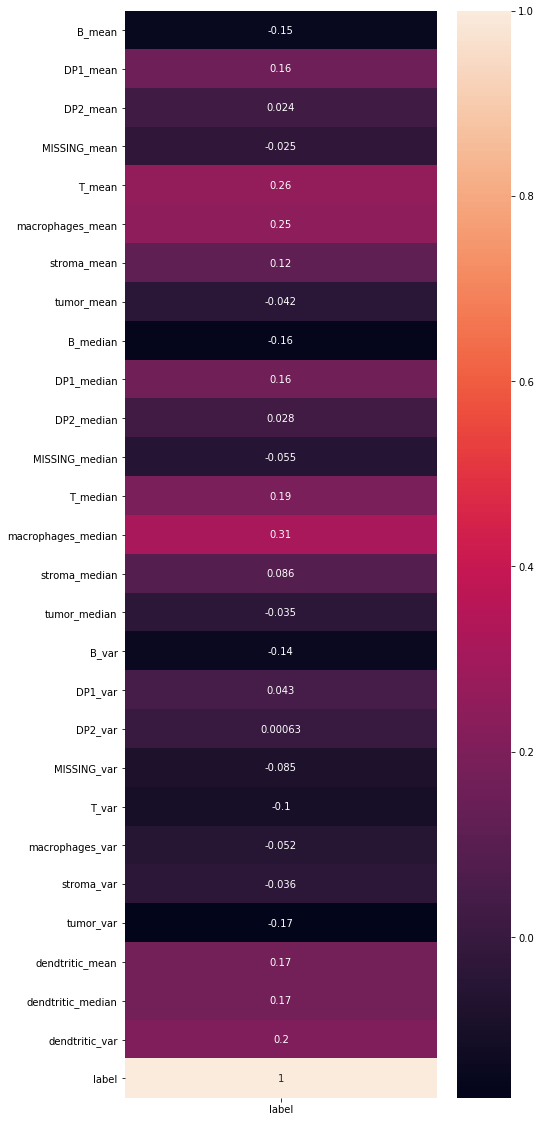

In [225]:
correlation_nodes = clus_coef_df.corr()
f, ax = plt.subplots(figsize=(7, 20))
ax = sns.heatmap(correlation_nodes.iloc[:,27:],annot=True)
plt.savefig(PLOT_DIRECTORY + 'clustering_coefficients_correlation_label.png')


In [226]:
pca = PCA(n_components=3)
label = clus_coef_df.label.values
features_scaled= clus_coef_df.drop(['name','label'],axis=1)
principalComponents = pca.fit_transform(features_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
principalDf['label'] = label

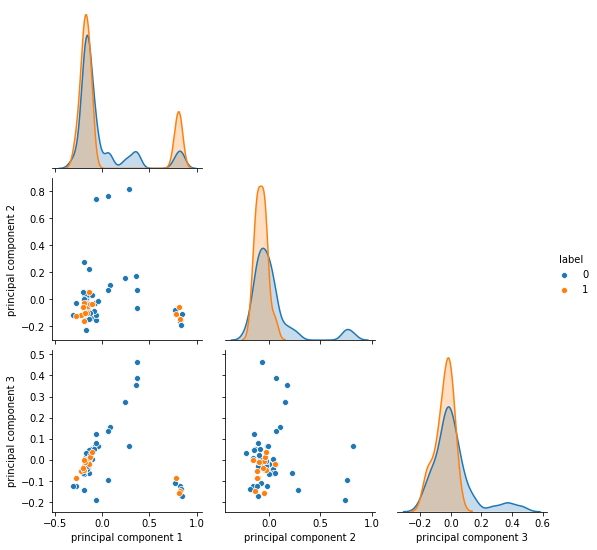

In [227]:
sns.pairplot(principalDf, hue='label', corner =True).savefig(PLOT_DIRECTORY+'clustering_Coefficients_PCA.png')

In [228]:
pca.explained_variance_ratio_

array([0.60810286, 0.22995812, 0.08605472])

iteration: 0
Training Error :
True y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
Predicted y_train : [1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 0 0 0 0]
[[31  3]
 [ 7  3]]
Testing Error :
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[14  1]
 [ 4  0]]
iteration: 1
Training Error :
True y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
Predicted y_train : [1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1
 0 1 1 1 1 1 0]
[[ 6 28]
 [ 0 10]]
Testing Error :
[1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[ 1 14]
 [ 0  4]]
iteration: 2
Training Error :
True y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
Predicted y_train : [1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1
 1 1 0 

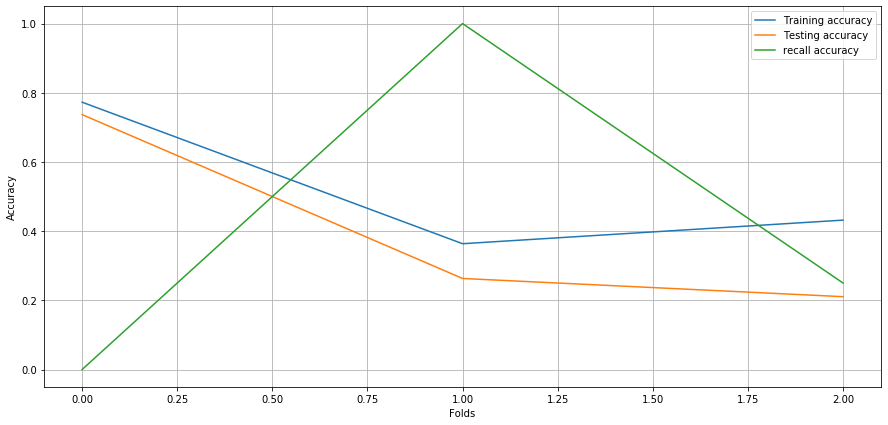

In [239]:
fit_model(clus_coef_df,'clustering_coef','rbf',3,2,5)

In [215]:
n = len(clus_coef_df.columns)

In [216]:
X = clus_coef_df.drop(['name','label'],axis=1)
Y = clus_coef_df.label.values

In [217]:
weight =20
model = RandomForestClassifier(max_depth=6, random_state=0,class_weight={0:1,1:weight})
model.fit(X,Y)
y_pred = model.predict(X)
confusion_matrix(Y,y_pred)

array([[48,  1],
       [ 0, 14]])

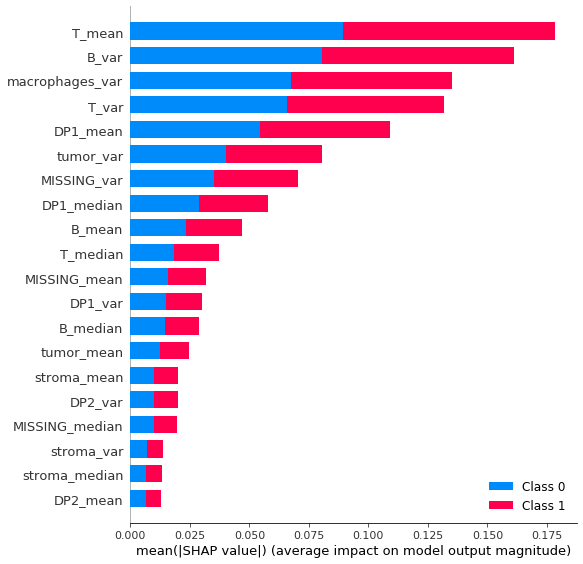

In [218]:
shap.initjs()
f, ax = plt.subplots(figsize=(15, 15))
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, features=X, feature_names=X.columns)


## Nodes edges count Classification  : 3 folds splits 

In [219]:
MODEL = 'rbf'

if MODEL == 'logistic':
    clf = SGDClassifier(loss = 'log', max_iter=1000, tol=1e-3, shuffle = True, learning_rate = 'adaptive',eta0=5, class_weight ='balanced',validation_fraction = 0.01)
            
if MODEL == 'hinge':
    clf = SGDClassifier(loss = 'hinge', max_iter=1000, tol=1e-3, shuffle = True, learning_rate = 'adaptive',eta0=5, class_weight ='balanced',validation_fraction = 0.01)
            
if MODEL == 'rbf' :  
    clf = svm.SVC(C= 1, kernel ='rbf', class_weight='balanced')
            
if MODEL == 'poly':     
    clf = svm.SVC(C= 1, kernel ='poly', class_weight='balanced')
    
    
    
clf.fit(X,y)
y_hat = clf.predict(X)
confusion_matrix(y,y_hat)

array([[46,  3],
       [10,  4]])